<a href="https://colab.research.google.com/github/jnramirezg/medio_continuo/blob/main/codigo/32-analisis_viga_en_voladizo_airy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis viga en voladizo con Airy (sección 5.14)

|Quién | Fecha | Qué hizo |
| ---  | ---   | ---      |
|Juan Nicolás Ramírez, <jnramirezg@unal.edu.co> | 2023-Mar-25 | Conversión de código de MAXIMA a Python|
|Diego Andrés Alvarez Marín,   <daalvarez@unal.edu.co>  | 2023-Sep-03 | Comentarios varios y mejorando el código |

[Código original](https://github.com/diegoandresalvarez/solidos/blob/master/archivos/codigo/cap_05/5.14_ejer_10_viga_voladizo_Airy.mac)

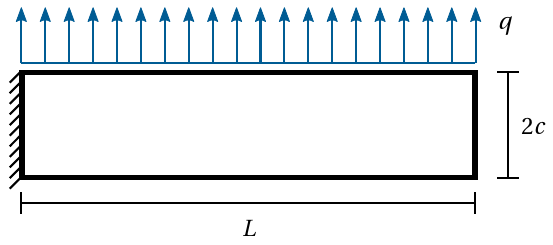

Importamos las librerias y funciones necesarias:

In [1]:
from sympy import symbols, diff, integrate, solve, factor, expand, collect, Rational, Add
import sympy as sp

# Para imprimir bonito
sp.init_printing()
from IPython.display import Math                 
def imprimir (texto1, variable, texto2=""):
    return Math(texto1 +  rf'{sp.latex(variable)}' + texto2)

Creo un macro de $\LaTeX$ para hacer el código más legible (dar doble clic a esta celda)
$\newcommand{\dd}{\operatorname{d} \!}$

Creamos las variables simbólicas:

In [2]:
C1, C2, C3, C4 = symbols("C1,C2,C3,C4")  # Constantes de la función de tensión de Airy
x, y, z    = symbols("x, y, z")                     # Coordenadas
K2         = symbols("K_2")                         # Constante de la ecuación biarmónica de Airy
c, L, q    = symbols("c, L, q")                     # Propiedades de la viga
E, nu      = symbols("E, nu")                       # Propiedades del material
u0, v0, w0 = symbols("u0, v0, omega_0")             # Constante de integración

In [3]:
t = 1  # [m]: espesor
V = 0  # V=0, ya que no se considerarán las fuerzas másicas

Proponemos la función de tensión de Airy:

In [4]:
phi = C1*(L-x)**2 + C2*(L-x)**2*y + C3*y**3 + C4*y**5 - 5*C4*(L-x)**2*y**3
imprimir(r"\phi(x,y) = ", phi)

<IPython.core.display.Math object>

Definimos el laplaciano $\nabla^2 f := \frac{\partial^2 f}{\partial x^2} +  \frac{\partial^2 f}{\partial y^2}$ y el biarmónico $\nabla^4 f := \nabla^2 \left(\nabla^2 f\right)$ de una función $f$:

In [5]:
lapl = lambda f: diff(f,x,2) + diff(f,y,2)
biar = lambda f: lapl(lapl(f))

Verificamos que se satisfaga la ecuación $\nabla^4\phi=K_2\nabla^2V$

In [6]:
if biar(phi) - K2*lapl(V) == 0:
    print("La ecuación biarmónica se satisface.")
else:
    raise Exception("La ecuación biarmónica no se satisface.")

La ecuación biarmónica se satisface.


# Cálculo de los esfuerzos

Definimos los esfuerzos utilizando la función de tensión de Airy:
$$\sigma_x(x,y)=\frac{\partial^2 \phi(x,y)}{\partial y^2} + V(x,y)$$
$$\sigma_x(x,y)=\frac{\partial^2 \phi(x,y)}{\partial x^2} + V(x,y)$$
$$\tau_{xy}(x,y)=-\frac{\partial^2 \phi(x,y)}{\partial x \partial y}$$

In [7]:
sx  =  diff(phi, y,2) + V
sy  =  diff(phi, x,2) + V
txy = -diff(phi, x,1, y,1)

In [8]:
imprimir(r"\sigma_x(x,y) = ", sx)

<IPython.core.display.Math object>

In [9]:
imprimir(r"\sigma_y(x,y) = ", sy)

<IPython.core.display.Math object>

In [10]:
imprimir(r"\tau_{xy}(x,y) = ", txy)

<IPython.core.display.Math object>

Definimos la fuerza cortante, el momento flector y la fuerza axial:
\begin{align}
V(x)         &= -\int_{-c}^{c}\int_{0}^{t}{\tau_{xy}(x,y,z)}\dd z \dd y \\
M(x)         &= -\int_{-c}^{c}\int_{0}^{t}{y\sigma_x(x,y,z)}\dd z \dd y \\
f_{\text{axial}}(x) &= \phantom{-}\int_{-c}^{c}\int_{0}^{t}{\sigma_x(x,y,z)} \dd z \dd y = 0
\end{align}

In [11]:
V   = lambda xx : -integrate(txy.subs(x,xx),   (z,0,t), (y,-c,c))
M   = lambda xx : -integrate( sx.subs(x,xx)*y, (z,0,t), (y,-c,c))
fax =              integrate( sx,              (z,0,t), (y,-c,c))

Establecemos las condiciones de frontera sobre los esfuerzos:
\begin{align}
 \tau_{xy}(x,y=\pm c,z) &= 0 &&\text{($\tau_{xy} = 0$ en el borde superior e inferior de la viga)}\\
 \sigma_y(x,y=-c,z)     &= 0 &&\text{(el borde inferior no soporta cargas)}  \label{eq:cfyviga}\\
 \sigma_y(x,y=+c,z)     &= \frac{q}{t} && \text{(el borde superior soporta la carga distribuida).}
\end{align}

In [12]:
e1 = txy.subs(y, +c) - 0    # =0
e2 = txy.subs(y, -c) - 0    # =0
e3 =  sy.subs(y, +c) - q/t  # =0
e4 =  sy.subs(y, -c) - 0    # =0

Establecemos unas condiciones de frontera con respecto a las fuerzas cortantes, los momentos flectores y las fuerzas axiales.

La fuerza cortante y el momento flector en los extremos de la viga están dados por:
\begin{align}
 V(0)        &= - q L &
 V(L)        &= 0 \\
 M(0)        &= \frac{q L^2}{2} &
 M(L)        &= 0
 \end{align} 
mientras que la fuerza axial para todo $x\in[-L,L]$ es
\begin{equation}
 f_\text{axial}(x) = 0.
\end{equation}

In [13]:
e5 = V( 0) - (-q*L)      # =0
e6 = V(+L) - 0           # =0
e7 = M( 0) - (q*L**2/2)  # =0
e8 = M(+L) - 0           # =0
e9 = fax   - 0           # =0 para todo x en [−L, L]

Utilizando las ecuaciones ```e1``` a ```e9``` encontramos las constantes ```C1```, ```C2```, ```C3``` y ```C4```, y las imprimimos:

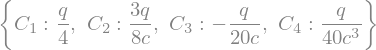

In [14]:
const = solve([e1,e2,e3,e4,e5,e6,e7,e8,e9], [C1,C2,C3,C4])

const

Reemplazamos ```C1```, ```C2```, ```C3``` y ```C4``` en los esfuerzos ```sx```, ```sy``` y ```txy```:

In [15]:
sx  = factor(sx.subs(const))
sy  = factor(sy.subs(const))
txy = factor(txy.subs(const))

Y los imprimimos:

In [16]:
imprimir(r"\sigma_x(x,y) = ", sx)

<IPython.core.display.Math object>

In [17]:
imprimir(r"\sigma_y(x,y) = ", sy)

<IPython.core.display.Math object>

In [18]:
imprimir(r"\tau_{xy}(x,y) = ", txy)

<IPython.core.display.Math object>

# Cálculo de las deformaciones

Definimos el módulo de rigidez:
\begin{equation}
G = \frac{E}{2(1 + \nu)}
\end{equation}

In [19]:
G = E/(2*(1+nu))

Usamos las ecuaciones de ley de Hooke de tensión plana para materiales isótropos para calcular las deformaciones:
\begin{align}
   \varepsilon_x & = \frac{1}{E} \left(\sigma_x - \nu\sigma_y\right)& \gamma_{xy} & = \frac{1}{G}\,\tau_{xy}\\
   \varepsilon_y & = \frac{1}{E} \left(\sigma_y - \nu\sigma_x\right)& \gamma_{yz} & = 0  \label{eq:epsilontensionplana_orto}\\
   \varepsilon_z & = -\frac{\nu}{E} \left(\sigma_x + \sigma_y \right)  & \gamma_{xz} & = 0.
\end{align}

In [20]:
ex  = factor((1/E)*(sx - nu*sy))
ey  = factor((1/E)*(sy - nu*sx))
gxy = factor((1/G)*txy)

In [21]:
imprimir(r"\varepsilon_x(x,y) = ", ex)

<IPython.core.display.Math object>

In [22]:
imprimir(r"\varepsilon_y(x,y) = ", ey)

<IPython.core.display.Math object>

In [23]:
imprimir(r"\gamma_{xy}(x,y) = ", gxy)

<IPython.core.display.Math object>

# Cálculo de los desplazamientos

De las fórmulas:
\begin{align}
u(x,y) &= \int\varepsilon_x(x',y)\dd x'+f(y)\\
v(x,y) &= \int\varepsilon_y(x,y')\dd y'+g(x)\\
\frac{\dd  f(y)}{\dd y} + \frac{\dd g(x)}{\dd x} &= \gamma_{xy}(x,y)-\frac{\partial}{\partial y}\left( \int\varepsilon_x(x',y)\dd  x'\right) -\frac{\partial}{\partial x}\left(\int\varepsilon_y(x,y')\dd y' \right)
\end{align}

Usamos la tercera ecuación:

In [24]:
df_dy_dg_dx = factor(gxy - diff(integrate(ex,x),y) - diff(integrate(ey,y),x))

imprimir(r"\frac{\dd f(y)}{\dd y} + \frac{\dd g(x)}{\dd x} = ", df_dy_dg_dx)

<IPython.core.display.Math object>

Descomponemos la ecuación diferencial en:
\begin{align}
\frac{\dd f(y)}{\dd y} &= \text{términos en función de $y$ únicamente} + \text{constantes} + \omega_0=0\\
\frac{\dd g(x)}{\dd x} &= \text{términos en función de $x$ únicamente} - \omega_0=0
\end{align}

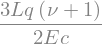

In [25]:
terminos_constantes = factor(df_dy_dg_dx.subs([(x,0), (y,0)]))

terminos_constantes

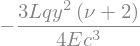

In [26]:
terminos_en_y = factor(df_dy_dg_dx.subs(x,0) - terminos_constantes)

terminos_en_y

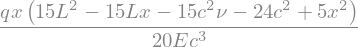

In [27]:
terminos_en_x = factor(df_dy_dg_dx.subs(y,0) - terminos_constantes)

terminos_en_x

In [28]:
df_dy = terminos_en_y + terminos_constantes + w0

imprimir(r"\frac{\dd f(y)}{\dd y} =", df_dy)

<IPython.core.display.Math object>

In [29]:
dg_dx = terminos_en_x - w0

imprimir(r"\frac{\dd g(x)}{\dd x} =", dg_dx)

<IPython.core.display.Math object>

De esta forma:
\begin{equation}
\frac{\dd f(y)}{\dd y}+\frac{\dd g(x)}{\dd x} = \underbrace{\omega_{0} + \frac{3 L q \left(\nu + 1\right)}{2 E c} - \frac{3 L q y^{2} \left(\nu + 2\right)}{4 E c^{3}}}_{\frac{\dd f(y)}{\dd y}} + \underbrace{\frac{q x \left(15 L^{2} - 15 L x - 15 c^{2} \nu - 24 c^{2} + 5 x^{2}\right)}{20 E c^{3}} -\omega_{0}}_{\frac{\dd g(x)}{\dd x}}
\end{equation}

Ahora, calculamos $f$ y $g$:

In [30]:
f = integrate(df_dy, y) + u0

imprimir("f(y) =", f)

<IPython.core.display.Math object>

In [31]:
g = integrate(dg_dx, x) + v0

imprimir("g(x) =", expand(g))

<IPython.core.display.Math object>

Finalmente, calculamos los desplamientos $u$ y $v$:
\begin{align}
       u(x,y) = \int \varepsilon_x(x',y) \dd x' + f(y) \\
       v(x,y) = \int \varepsilon_y(x,y') \dd y' + g(x)
\end{align}

In [32]:
u = integrate(ex, x) + f

imprimir("u(x,y) =", u)

<IPython.core.display.Math object>

In [33]:
v = integrate(ey, y) + g

imprimir("v(x,y) =", v)

<IPython.core.display.Math object>

Sólo resta encontrar los valores de $u_0$, $v_0$ y $\omega_0$ a partir de las condiciones de frontera y el conocimiento que en el empotramiento de la viga los desplazamientos y la rotación son nulas:
\begin{align}
u( 0, y)     &= 0 &
v(0, y)      &= 0 &
\theta(0, y) &= 0
\end{align}

In [34]:
rot = (diff(v,x) - diff(u,y))/2  # rotación en un punto

In [35]:
e1 =   u.subs([(x, 0)]) - 0  # = 0   el desplazamiento horizontal en el extremo izquierdo es nulo
e2 =   v.subs([(x, 0)]) - 0  # = 0   el desplazamiento vertical en el extremo izquierdo es nulo
e3 = rot.subs([(x, 0)]) - 0  # = 0   la rotación en el extremo izquierdo es nulo

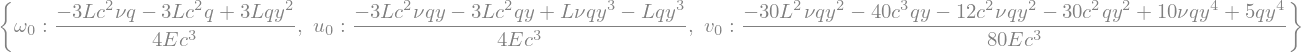

In [36]:
u0v0w0 = solve([e1, e2, e3],[u0, v0, w0])

u0v0w0

Donde las constantes de integración son:

In [37]:
imprimir("u_0=", factor(u0v0w0[u0]))

<IPython.core.display.Math object>

In [38]:
imprimir("v_0=", factor(u0v0w0[v0]))

<IPython.core.display.Math object>

In [39]:
imprimir(r"\omega_0=", factor(u0v0w0[w0]))

<IPython.core.display.Math object>

Reemplazamos las constantes de integración:

In [40]:
u = factor(u.subs(u0v0w0))
v = factor(v.subs(u0v0w0))

Obtenemos los desplazamientos de la viga:

In [41]:
imprimir(r"u(x,y) = ", u)

<IPython.core.display.Math object>

In [42]:
imprimir(r"v(x,y) = ", v)

<IPython.core.display.Math object>

# Comparación de la teoría de Euler-Bernoulli con lo estimado por la teoría de la elasticidad

Nota: falta mejorar bastante la claridad de esta sección

Por último, la deflexión vertical de la viga en el punto $x=L$, $y=0$ es:

In [43]:
v_L_0 = v.subs([(x,L), (y,0)])
imprimir(r"v(L,0) = ", factor(v_L_0))

<IPython.core.display.Math object>

Reemplazamos $\frac{2tc^3}{3}$ por $I$:

In [44]:
I  = symbols("I")
Ib = 2*t*c**3/3
v_L_0 = v_L_0*Ib/I  # Es equivalente a multiplicar por uno.

Primera forma de factorizar la expresión:

In [45]:
ec1 = Add(expand(v_L_0/(Rational(1,8)*q*L**4/(E*I))) * (Rational(1,8)*q*L**4/(E*I)),
          evaluate=False)
imprimir(r"v(0,0) =", ec1)

<IPython.core.display.Math object>

Segunda forma de factorizar la expresión:

In [46]:
_2c = symbols("(2c)")
ec2 = collect(ec1.subs(c, _2c/2), _2c**2/L**2)
imprimir(r"v(0,0) =", ec2)

<IPython.core.display.Math object>

En este caso, el parámetro $h/L$ viene representado de forma equivalente por $2c/L$. Por lo tanto, el % de variación respecto a la teoría de Euler-Bernoulli (revisar [este programa](https://github.com/jnramirezg/medio_continuo/blob/main/codigo/29-modelo_viga_voladizo.ipynb)) viene dado por:
$$\left(\frac{3\nu}{2}+\frac{6}{5}\right)\left(\frac{2c}{L}\right)^2 = \left(\frac{3\nu}{2}+\frac{6}{5}\right)\left(\frac{h}{L}\right)^2$$

Suponiendo $\nu=0.3$, por ejemplo, para $2c/L=h/L=[0.05, 0.1, 0.25]$:

In [47]:
nu=0.3

In [48]:
h_L=0.05
(3*nu/2+6/5)*(h_L)**2

In [49]:
h_L=0.1
(3*nu/2+6/5)*(h_L)**2

In [50]:
h_L=0.25
(3*nu/2+6/5)*(h_L)**2